**Цель проекта:**

**Разработать и внедрить две модели машинного обучения для:**

- **Предсказания уровня удовлетворённости сотрудников работой в компании.**

- **Прогнозирования вероятности увольнения сотрудника из компании.**

**План работы:**

**1. Загрузка данных**

**2. Предобработка данных**

- **2.1. Анализ пропусков в столбцах, удаление строк с пропусками.**
- **2.2. Поиск аномальных значений.**
- **2.3. Удаление явных дубликатов.**
- **2.4. Приведение типов данных к нужному формату.**
- **2.5. Поиск и устранение неявных дубликатов.**


**3. Исследовательский анализ данных**

- **Анализ распределений и взаимосвязей между основными переменными для выявления ключевых факторов, которые оказывают влияние на уровень удовлетворенности сотрудников и их склонность к увольнению. Рассмотрение корреляций и других статистических показателей для нахождения значимых зависимостей.**

**4. Подготовка данных для моделирования:**

- **Кодирование категориальных признаков.**


- **Масштабирование числовых переменных для приведения их к единой шкале и обеспечения корректной работы моделей.**

**5. Обучение и оценка моделей машинного обучения:**

- **обучить модель для прогнозирования уровня удовлетворённости сотрудников.** 

- **обучить модель для предсказания вероятности увольнения сотрудников.**

- **Оптимизация моделей путём подбора гиперпараметров и последующая оценка их эффективности.**

**6. Анализ результатов и формирование рекомендаций:**

- **Анализ и интерпретация полученных прогнозов.** 

- **Разработка практических рекомендаций для HR-отдела по повышению уровня удовлетворённости сотрудников и снижению вероятности их увольнения.**

**7. Итоговые выводы:**

- **Выделение основных результатов исследования.**

- **Разработка стратегических рекомендаций по оптимизации управления персоналом для повышения эффективности компании.**

In [1]:
!pip install shap -q
!pip install phik -q
!pip install --upgrade scikit-learn


# Шаг 1. Загрузка данных

In [2]:
# Импортируем библиотеки s
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import phik
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV, 
    GridSearchCV,
    KFold
)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    RobustScaler
) 
RANDOM_STATE=42
TEST_SIZE=0.25

In [3]:
try:
    job_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', decimal='.', sep=',')
    test_features = pd.read_csv('/datasets/test_features.csv', decimal='.', sep=',')
    test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', decimal='.', sep=',') 
except:
    job_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', decimal='.', sep=',')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', decimal='.', sep=',')
    test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', decimal='.', sep=',')


In [4]:
def descrb(df):
    # Выводим первые строки таблицы
    display(df.head(5))
    
    # Информация о типах данных и общем состоянии датафрейма
    display(df.info())
    
    # Подсчёт дубликатов и пропусков
    print(f'Найдено дубликатов: {df.duplicated().sum()}')
    print(f'Количество пропущенных значений по столбцам:\n{df.isnull().sum()}')


In [5]:
descrb (job_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

Найдено дубликатов: 0
Количество пропущенных значений по столбцам:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [6]:
descrb (test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

Найдено дубликатов: 0
Количество пропущенных значений по столбцам:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64


In [7]:
descrb (test_target)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Найдено дубликатов: 0
Количество пропущенных значений по столбцам:
id                       0
job_satisfaction_rate    0
dtype: int64


**После загрузки и первичного анализа данных могу отметить, что структура колонок соответствуют стандартам. Также, как было проверено, в данных нет явных дубликатов. Однако в некоторых таблицах присутствуют пропуски, которые позже потребуется обработать. В целом, критических замечаний на этапе загрузки и просмотра данных не возникло, и дальнейшие шаги будут направлены на корректную предобработку.**

# Шаг 2. Предобработка данных

In [8]:
def show_cat_info(df):
    # Отображаем первые строки для общего понимания структуры
    print("Пример данных:")
    display(df.head())
    
    # Выводим список всех столбцов с их типами данных для дальнейшего анализа
    print("\nНазвания и типы колонок:")
    for column in df.columns:
        print(f"{column}: {df[column].dtype}")


In [9]:
show_cat_info (job_satisfaction)

Пример данных:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Названия и типы колонок:
id: int64
dept: object
level: object
workload: object
employment_years: int64
last_year_promo: object
last_year_violations: object
supervisor_evaluation: int64
salary: int64
job_satisfaction_rate: float64


In [10]:
job_satisfaction['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [11]:
job_satisfaction['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [12]:
job_satisfaction['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [13]:
job_satisfaction['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [14]:
job_satisfaction['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [15]:
show_cat_info (test_features)

Пример данных:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Названия и типы колонок:
id: int64
dept: object
level: object
workload: object
employment_years: int64
last_year_promo: object
last_year_violations: object
supervisor_evaluation: int64
salary: int64


In [16]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [17]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [18]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [19]:
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [20]:
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [21]:
# Заменяем 'sinior' на 'senior' в колонке 'level'
test_features['level'].replace('sinior', 'senior', inplace=True)



# Исследовательский анализ данных

In [22]:
job_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [23]:
# создадим список с числовыми переменными
num_col=['salary', 'job_satisfaction_rate']
# создадим список с названиями графиков
title_num = ['ежемесячная зарплата сотрудника', 'уровень удовлетворённости сотрудника работой']

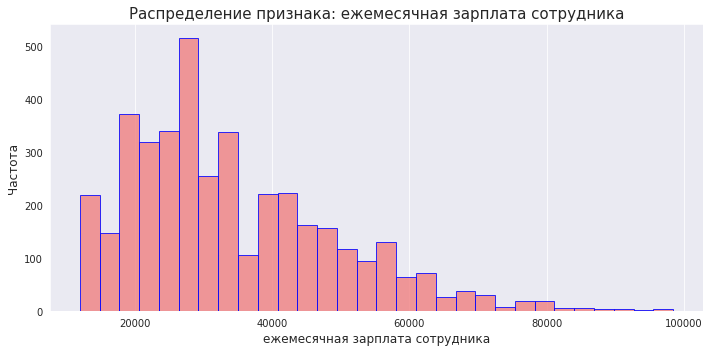

Статистика для признака ежемесячная зарплата сотрудника:
 count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


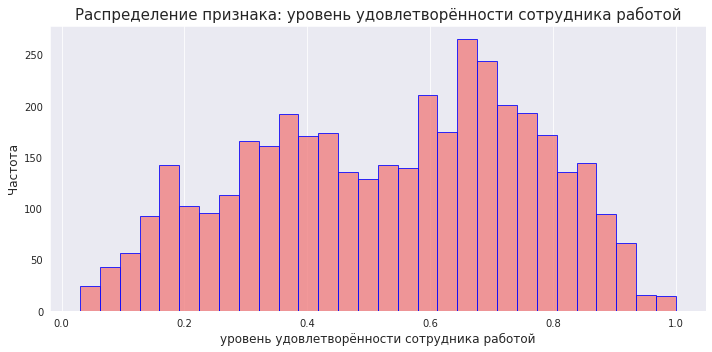

Статистика для признака уровень удовлетворённости сотрудника работой:
 count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [24]:
# Визуализация гистограмм с расчетом основных статистических показателей
for i in range(len(num_col)):
    sns.set_style('darkgrid') 
    plt.figure(figsize=(10, 5))  
    
    # Строим гистограмму 
    plt.hist(job_satisfaction[num_col[i]], color='lightcoral', edgecolor='blue', alpha=0.8, bins=30)
    
    # Настройки заголовков и подписей осей
    plt.title(f"Распределение признака: {title_num[i]}", fontsize=15)
    plt.xlabel(title_num[i], fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    
    # Отображение графика
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)  # Добавлена сетка по оси Y
    plt.show()
    
    # Выводим основные статистические данные
    print(f"Статистика для признака {title_num[i]}:\n", job_satisfaction[num_col[i]].describe())


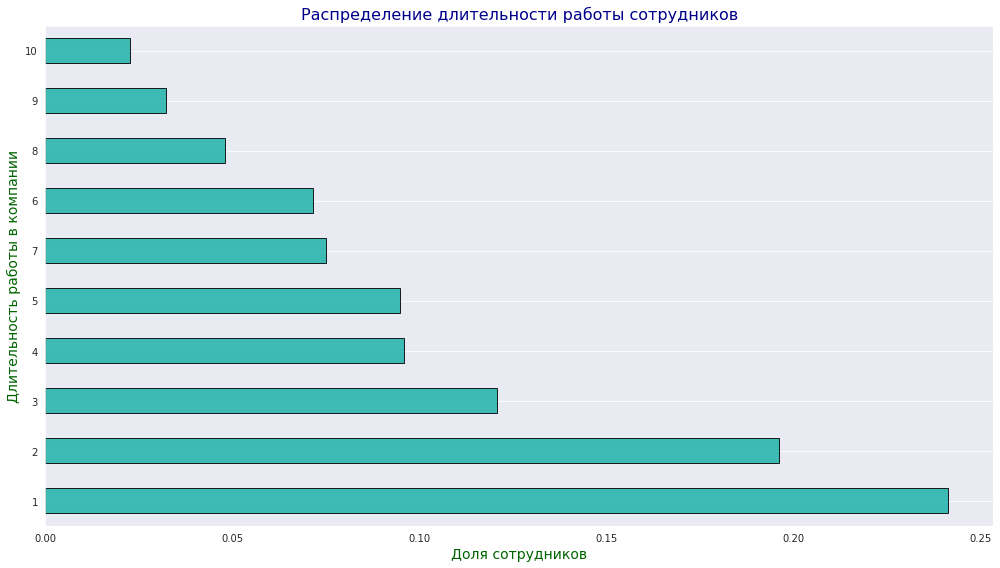

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


In [25]:
# Визуализация распределения длительности работы в компании
job_satisfaction['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(14, 8), 
                                                                       color='lightseagreen', edgecolor='black', alpha=0.85, grid=True)

# Настройка заголовков и подписей осей
plt.title('Распределение длительности работы сотрудников', fontsize=16, color='darkblue')
plt.xlabel('Доля сотрудников', fontsize=14, color='darkgreen')
plt.ylabel('Длительность работы в компании', fontsize=14, color='darkgreen')

# Отображение графика
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавлена сетка по оси X
plt.show()

# Статистика по длительности работы
print(job_satisfaction['employment_years'].describe())


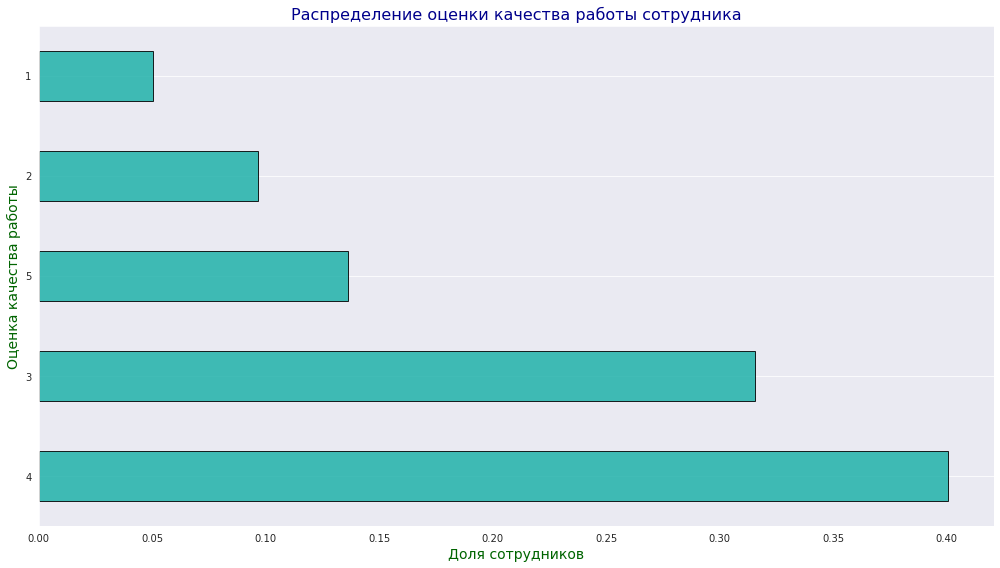

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [26]:
# Визуализация распределения оценки качества работы сотрудников
job_satisfaction['supervisor_evaluation'].value_counts(normalize=True).plot(kind='barh', figsize=(14, 8), 
                                                                           color='lightseagreen', edgecolor='black', alpha=0.85, grid=True)

# Настройка заголовков и подписей осей
plt.title('Распределение оценки качества работы сотрудника', fontsize=16, color='darkblue')
plt.xlabel('Доля сотрудников', fontsize=14, color='darkgreen')
plt.ylabel('Оценка качества работы', fontsize=14, color='darkgreen')

# Отображение графика
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавлена сетка по оси X
plt.show()

# Статистика по оценке качества работы
print(job_satisfaction['supervisor_evaluation'].describe())


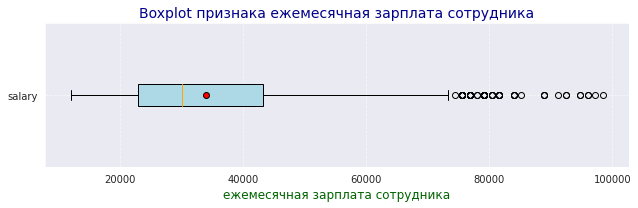

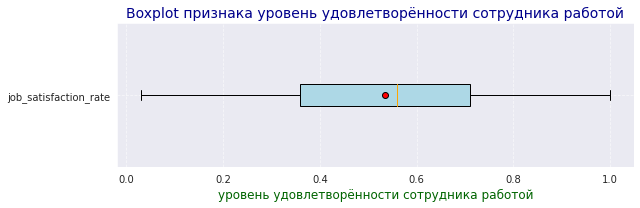

In [27]:
# Построение boxplot для каждого числового признака
for i in range(len(num_col)):
    plt.figure(figsize=(9, 3))  
    boxplot = job_satisfaction.boxplot(num_col[i], patch_artist=True, vert=False, showmeans=True, 
                                       boxprops=dict(facecolor='lightblue', color='black'),
                                       meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='black'),
                                       whiskerprops=dict(color='black'),
                                       capprops=dict(color='black'),
                                       medianprops=dict(color='orange'))
    
    # Настройка заголовка и осей
    plt.title(f"Boxplot признака {title_num[i]}", fontsize=14, color='darkblue')
    plt.xlabel(title_num[i], fontsize=12, color='darkgreen')
    
    # Добавление сетки
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



**Исследование показало, что большинство сотрудников имеют стаж работы от 1 до 6 лет, в среднем около 3 лет. Оценка их качества работы в основном на уровне 3-4 баллов, но есть один сотрудник с минимальной оценкой, который может оказаться кандидатом на увольнение. Средняя зарплата составляет 34 000 рублей, что ненамного выше медианы, с максимальной зарплатой в 98 400 и минимальной в 12 000 рублей. Удовлетворенность сотрудников работой соответствует их оценкам — в целом средний уровень, но есть потенциал для улучшения.**

In [28]:
# Создаём список с категориальными переменными
cat_col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

# Создаём список с названиями графиков
titles_cat_col = ['Отдел сотрудника', 'Должностной уровень', 'Загруженность на работе', 'Получение повышения за последний год', 'Нарушения трудового договора']


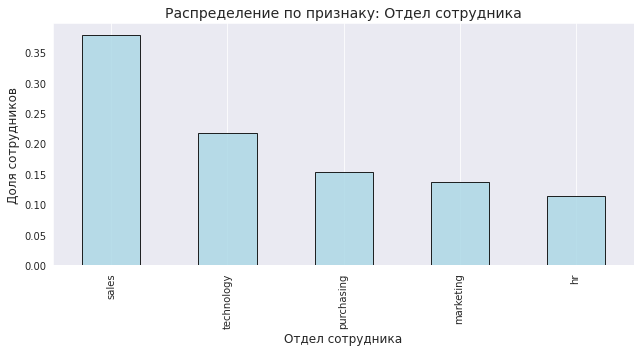

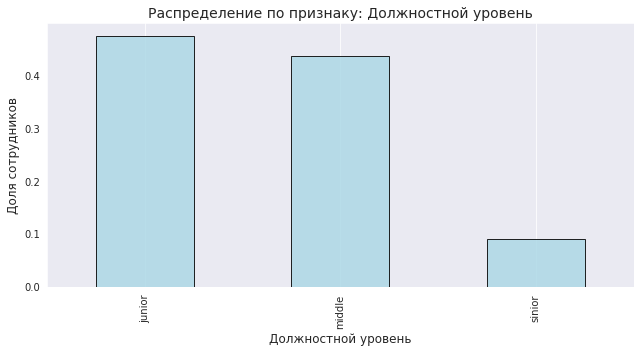

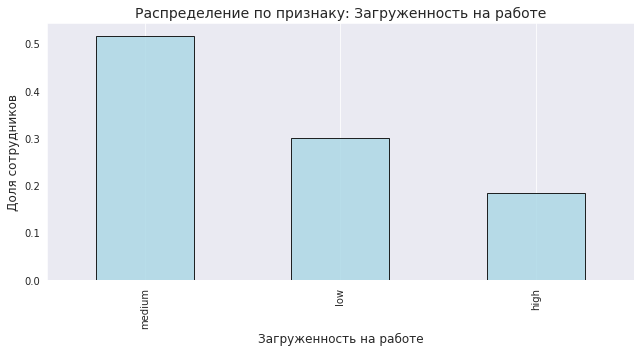

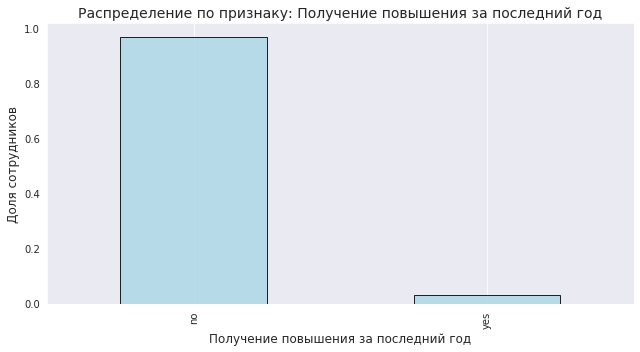

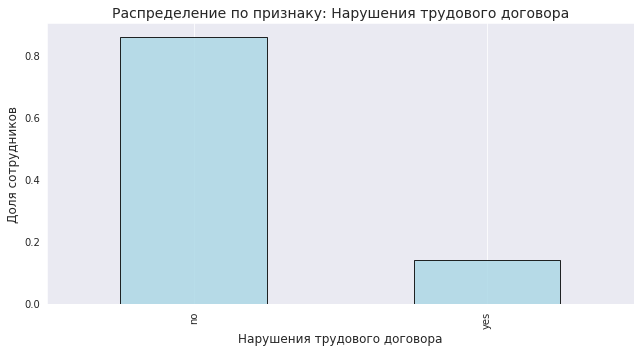

In [29]:
# Настроим отображение и визуализацию столбчатых диаграмм
for i in range(len(cat_col)):
    plt.figure(figsize=(9, 5))  # Сделаем графики чуть больше для лучшей читаемости
    job_satisfaction[cat_col[i]].value_counts(normalize=True).plot(
        kind='bar', color='lightblue', edgecolor='black', alpha=0.85)  # Изменим цвет и прозрачность
    
    # Настраиваем заголовки и подписи
    plt.title(f"Распределение по признаку: {titles_cat_col[i]}", fontsize=14)
    plt.xlabel(titles_cat_col[i], fontsize=12)
    plt.ylabel('Доля сотрудников', fontsize=12)
    
    # Настроим сетку и улучшенную компоновку
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Добавим сетку для оси Y
    plt.tight_layout()  # Оптимизируем размещение
    plt.show()


**На основе анализа категориальных данных можно сделать несколько наблюдений. Большинство сотрудников представляют отдел продаж, за ними следует технологический отдел. Среди должностей преобладают сотрудники младшего уровня (junior), но немалую долю занимают сотрудники среднего уровня. Загруженность персонала находится на среднем уровне, но стоит обратить внимание на высокую долю сотрудников с низкой нагрузкой. Повышения за последний год были редкостью, что объясняется средним стажем работников в 3 года. Нарушения трудовой дисциплины встречаются нечасто, но их наличие требует внимания.**

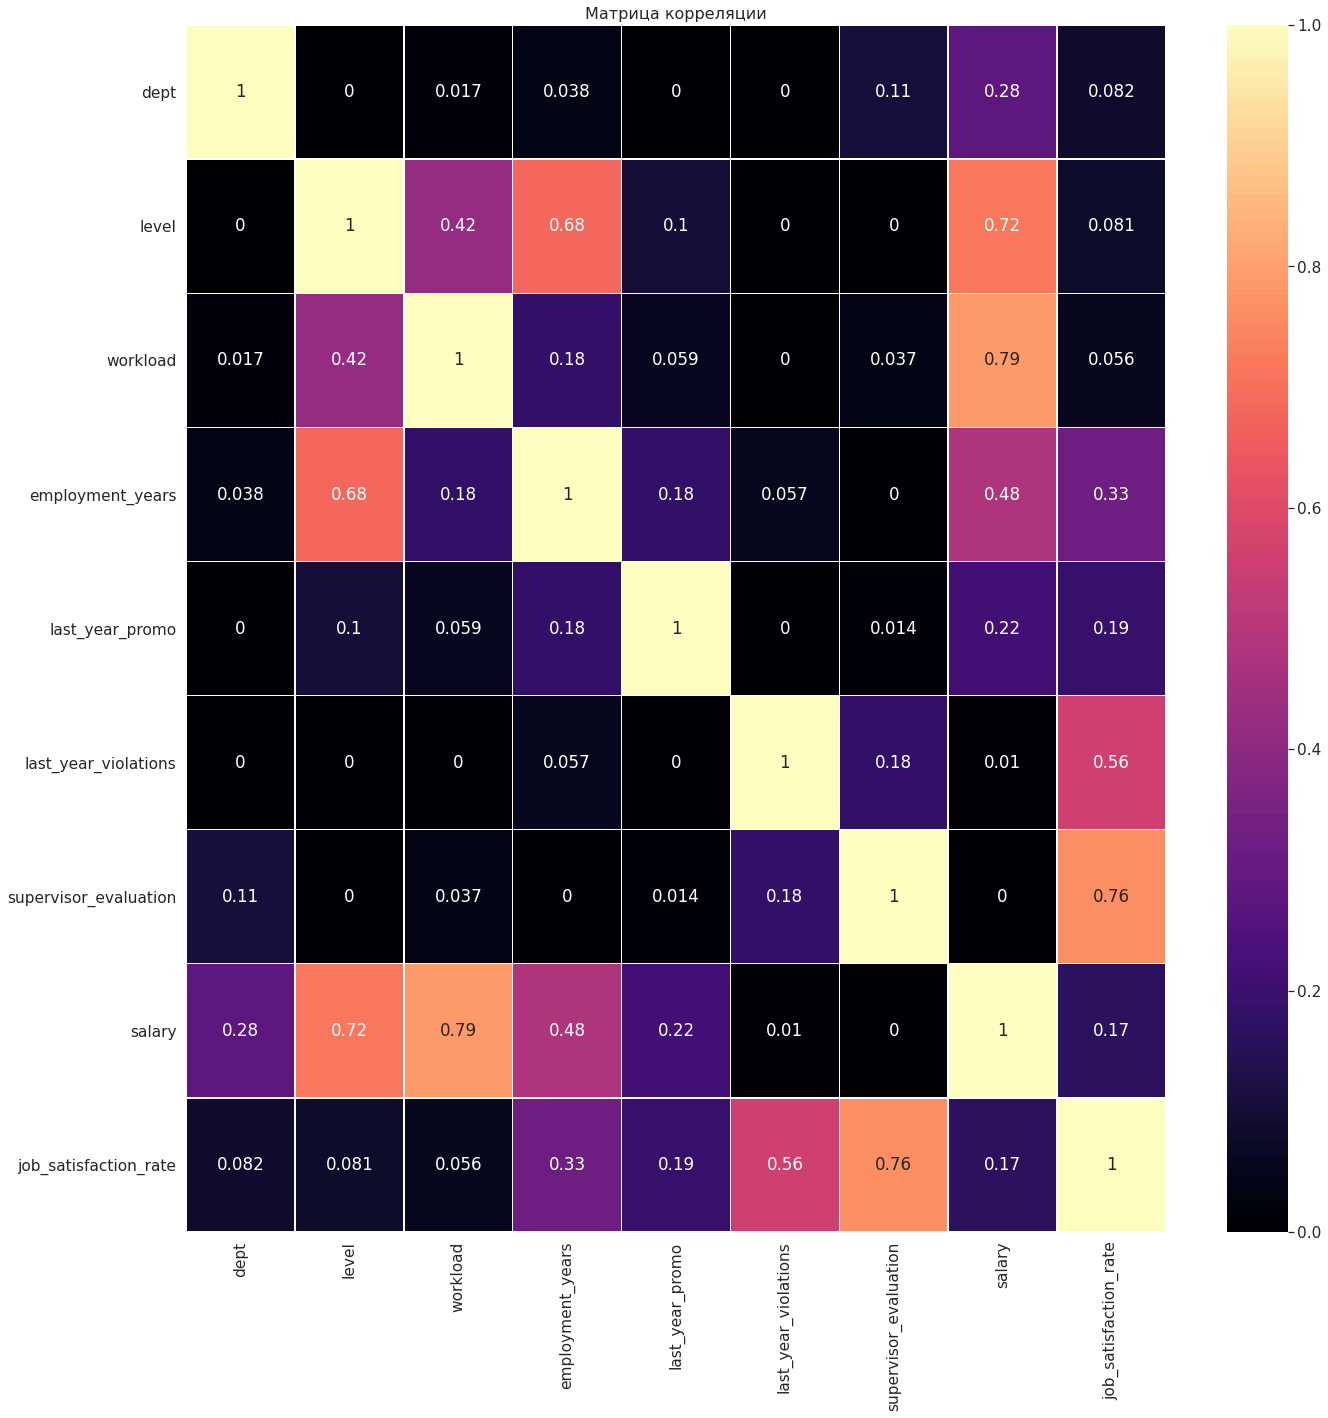

In [30]:
# Удаляем колонку 'id' и сохраняем новый датафрейм
job_satisfaction_1 = job_satisfaction.drop(['id'], axis=1)

# Вычисляем корреляционную матрицу для числовых переменных
corr_matrix = job_satisfaction_1.phik_matrix(interval_cols=num_col)

# Настраиваем параметры визуализации
sns.set(font_scale=1.4)
plt.figure(figsize=(20, 20))

# Построение тепловой карты с другой цветовой схемой 'magma'
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='magma')

# Добавляем заголовок
plt.title('Матрица корреляции', fontsize=16)

# Отображаем график
plt.tight_layout()
plt.show()


**Анализ корреляции показал, что уровень удовлетворённости сотрудника работой в компании наиболее связан с его отделом, должностью и оценкой качества работы. Несмотря на это, явных признаков сильной корреляции между переменными не выявлено, что говорит об отсутствии мультиколлинеарности. Следовательно, нет необходимости удалять какие-либо признаки из анализа, поскольку каждый из них предоставляет ценную информацию для построения модели.**

In [31]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [32]:
# создадим список с числовыми переменными
num_col_1=['salary']
# создадим список с названиями графиков
titles_num_1 = ['ежемесячная зарплата сотрудника']

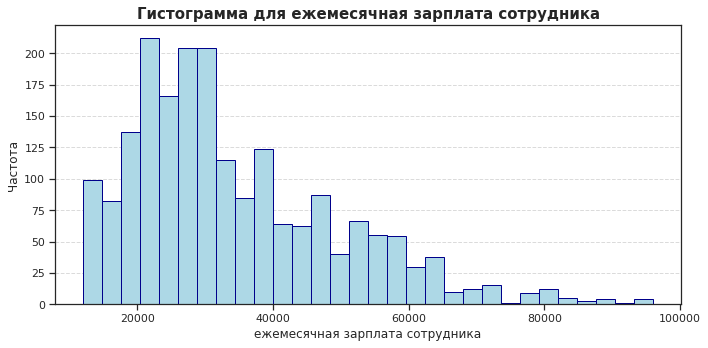

Статистика по ежемесячная зарплата сотрудника:
 count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64 



In [33]:
# Визуализация гистограмм и статистических показателей для числовых признаков
for feature in num_col_1:
    sns.set(style="ticks", palette="muted")  
    plt.figure(figsize=(10, 5))  
    plt.hist(test_features[feature], color='lightblue', edgecolor='darkblue', bins=30)  
    plt.title(f"Гистограмма для {titles_num_1[num_col_1.index(feature)]}", fontsize=15, fontweight='bold')
    plt.xlabel(titles_num_1[num_col_1.index(feature)], fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Добавлена сетка
    plt.tight_layout()
    plt.show()
    
    # Выводим описательную статистику для признака
    print(f"Статистика по {titles_num_1[num_col_1.index(feature)]}:\n", test_features[feature].describe(), '\n')


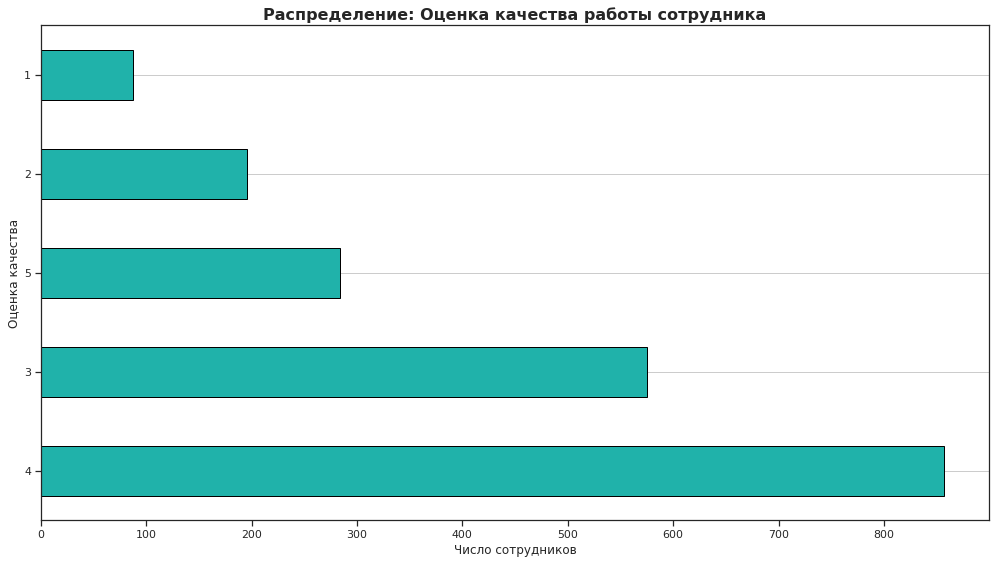

Статистика по оценке качества работы сотрудников:
count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [34]:
# Визуализация распределения оценки качества работы сотрудника с уникальными элементами
plt.figure(figsize=(14, 8))  
test_features['supervisor_evaluation'].value_counts().plot(kind='barh', color='lightseagreen', edgecolor='black', grid=True)

# Настраиваем заголовки и подписи
plt.title('Распределение: Оценка качества работы сотрудника', fontsize=16, fontweight='bold')
plt.xlabel('Число сотрудников', fontsize=12)
plt.ylabel('Оценка качества', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)  
plt.tight_layout()
plt.show()

# Выводим статистические данные для 'supervisor_evaluation'
print(f"Статистика по оценке качества работы сотрудников:\n{test_features['supervisor_evaluation'].describe()}")


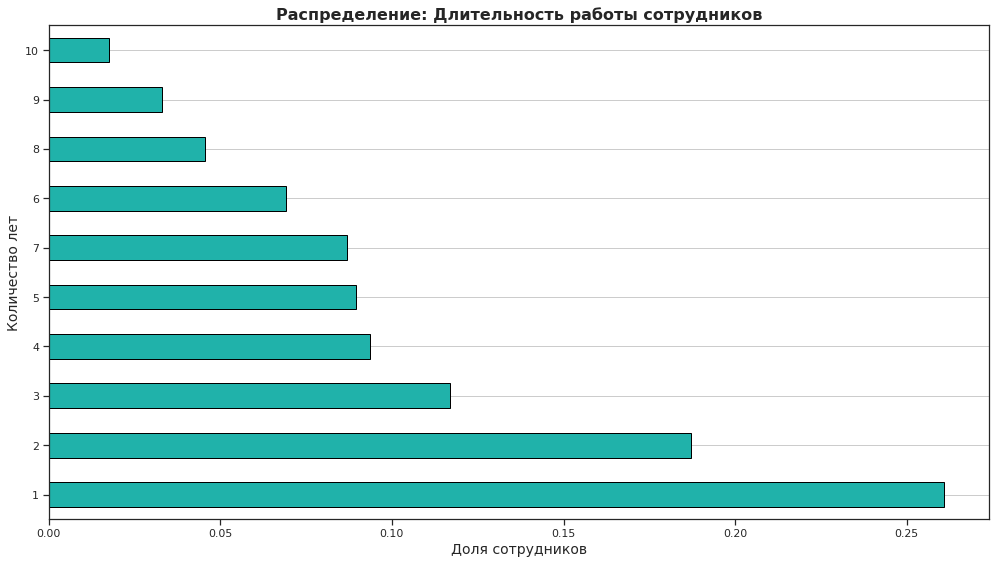

Статистика по длительности работы сотрудников:
count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


In [35]:
# Визуализация распределения длительности работы сотрудников с уникальными элементами
plt.figure(figsize=(14, 8))  # Изменен размер для лучшего отображения
test_features['employment_years'].value_counts(normalize=True).plot(
    kind='barh', color='lightseagreen', edgecolor='black', grid=True)

# Настройка заголовков и подписей осей
plt.title('Распределение: Длительность работы сотрудников', fontsize=16, fontweight='bold')
plt.xlabel('Доля сотрудников', fontsize=14)
plt.ylabel('Количество лет', fontsize=14)

# Настройка сетки
plt.grid(axis='x', linestyle=':', alpha=0.7)  
plt.tight_layout()
plt.show()

# Статистика по 'employment_years'
print(f"Статистика по длительности работы сотрудников:\n{test_features['employment_years'].describe()}")


In [36]:
# создадим список с категориальных перемен
cat_col_1=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
# создадим список с названиями графиков 
titles_cat_col_1= ['отдел, в котором работает сотрудник', 'уровень занимаемой должности', 'уровень загруженности сотрудника', 'Было ли повышение за последний год', 'нарушал ли сотрудник трудовой договор за последний год']

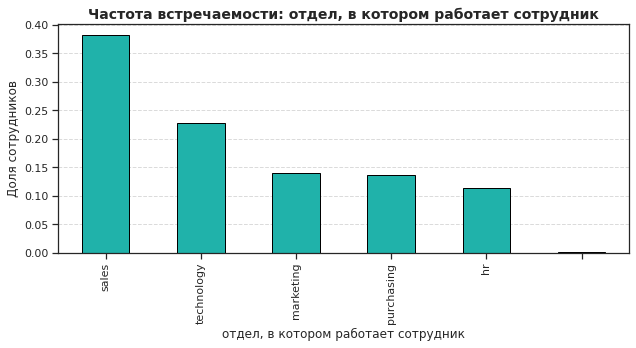

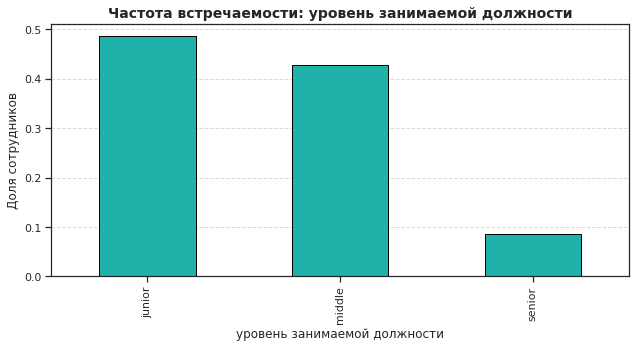

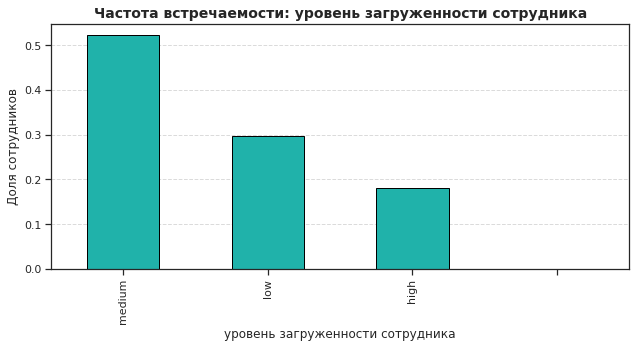

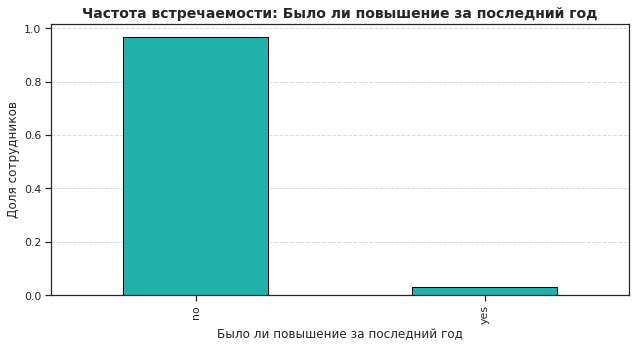

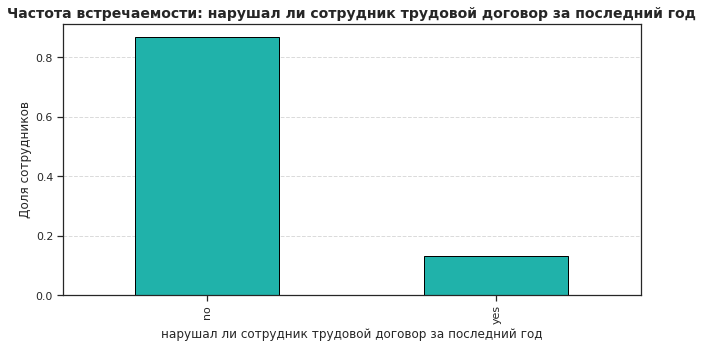

In [37]:
# Визуализируем распределение категориальных признаков
for i, col in enumerate(cat_col_1):
    plt.figure(figsize=(9, 5))  
    test_features[col].value_counts(normalize=True).plot(kind='bar', color='lightseagreen', edgecolor='black')

    # Добавлены заголовки и подписи с форматированием
    plt.title(f"Частота встречаемости: {titles_cat_col_1[i]}", fontsize=14, fontweight='bold')
    plt.xlabel(f'{titles_cat_col_1[i]}', fontsize=12)
    plt.ylabel('Доля сотрудников', fontsize=12)

    # Настройка сетки и плотного отображения
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


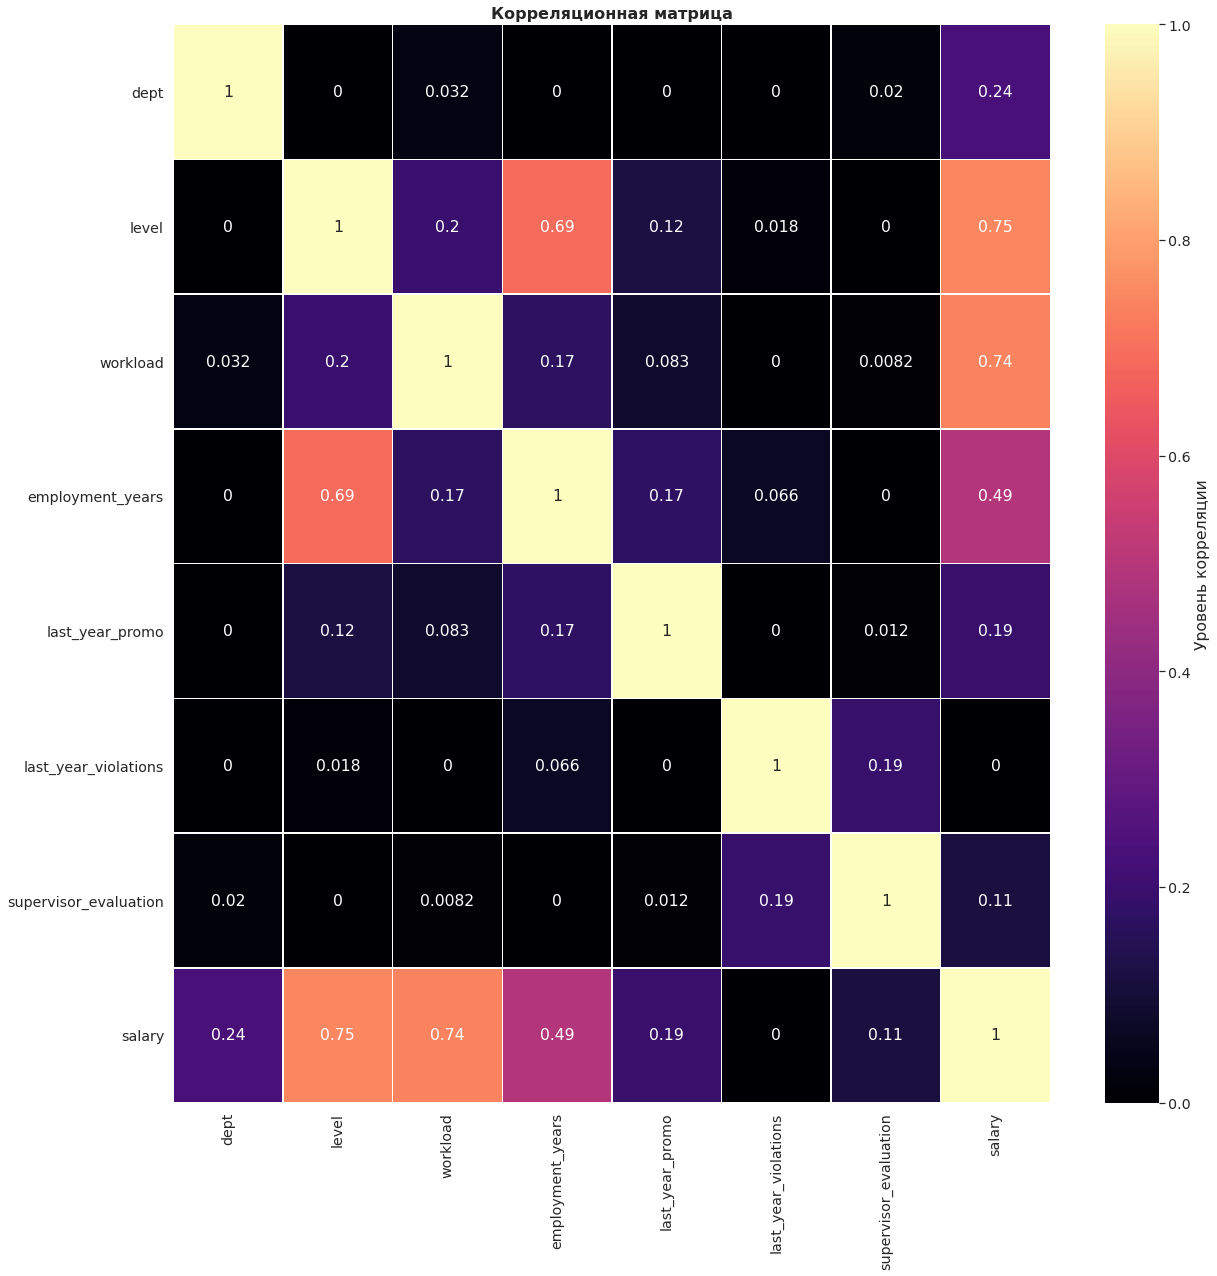

In [38]:
# Удаляем столбец 'id' для подготовки данных
test_features_clean = test_features.drop(columns=['id'])

# Вычисляем корреляционную матрицу с использованием Phik
corr_matrix = test_features_clean.phik_matrix(interval_cols=num_col)

# Настройка параметров графика
sns.set(font_scale=1.3)
plt.figure(figsize=(18, 18))

# Визуализация тепловой карты с измененной цветовой схемой
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='magma', cbar_kws={'label': 'Уровень корреляции'})

# Добавляем заголовок
plt.title('Корреляционная матрица', fontsize=16, fontweight='bold')

# Отображаем график
plt.tight_layout()
plt.show()


**При анализе данных без учета целевого признака не было выявлено существенных изменений или аномалий, что подтверждает их корректность.Для дальнейшей обработки данных подготовим пайплайн. Категориальные признаки, такие как отдел, повышения за последний год и нарушения, будут закодированы с помощью OneHotEncoder. Признаки уровня и загруженности сотрудников обработаем с помощью OrdinalEncoder. Количественные переменные, включая стаж работы, оценку от руководства и зарплату, подвергнутся масштабированию для лучшего результата в моделях.**

# Шаг 4. Обучение моделей

In [39]:
train_1 = job_satisfaction.drop(['id'], axis=1)
train_1.drop_duplicates(inplace=True)

In [40]:

X_train = train_1.drop('job_satisfaction_rate', axis=1)
y_train = train_1['job_satisfaction_rate'] 


# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']


ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])
 
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21),
        'models__min_samples_split': range(2, 21),
        'models__max_features': range(2, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]


def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))



smape_scorer = make_scorer(score_func=smape, greater_is_better=False)
 
# выберем лучшую модель и параметры с помощью RandomizedSearchCV()
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    n_iter=10,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# обучаем лучшую модель на тренировочных данных
r_search.fit(X_train, y_train)

# выводим на экран лучшую модель
print('Лучшая модель и её параметры:\n\n', r_search.best_estimator_)
print(f'Параметры лучшей модели:\n{r_search.best_params_}')
print ('Метрика лучшей модели на тренировочной выборке:', round(r_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [41]:
# Объединяем данные, чтобы добавить целевой признак к тестовой выборке
test_data_full = test_features.merge(test_target, on='id', how='left')

# Отделяем признаки и целевую переменную
X_test = test_data_full.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_data_full['job_satisfaction_rate']

# Извлекаем лучшую модель из поиска
optimal_model = r_search.best_estimator_

# Выводим метрику SMAPE для кросс-валидации на обучающей выборке
print(f'Оценка SMAPE лучшей модели на кросс-валидации: {round(r_search.best_score_ * (-1), 4)}')




Оценка SMAPE лучшей модели на кросс-валидации: 15.2016


**Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: 15.1814**


In [42]:
print(f'Метрика sMAPE лучшей модели на тестовой выборке: {round(smape(y_test, optimal_model.predict(X_test)),4)}')

Метрика sMAPE лучшей модели на тестовой выборке: 14.3139


**Мы обучили модель, используя пайплайн с моделями DecisionTreeClassifier и LinearRegression. По итогам настройки гиперпараметров была выбрана лучшая модель, которая показала хорошие результаты. Основные параметры этой модели: max_depth - 17, min_samples_split - 12, max_features - 10, с использованием стандартизации данных через StandardScaler. На тренировочной модель продемонстрировала результат с метрикой -15.2, а по SMAPE на кросс-валидации оценка составила 15.2016. На тестовой выборке модель показала результат SMAPE в 14.314**

# Задача 2

In [43]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', decimal='.', sep=',')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', decimal='.', sep=',')
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', decimal='.', sep=',')

In [44]:
descrb (train_quit)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

Найдено дубликатов: 0
Количество пропущенных значений по столбцам:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


In [45]:
descrb(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

Найдено дубликатов: 0
Количество пропущенных значений по столбцам:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64


In [46]:
descrb(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

Найдено дубликатов: 0
Количество пропущенных значений по столбцам:
id      0
quit    0
dtype: int64


**При загрузке и первичном осмотре данных не выявлено никаких серьёзных ошибок. Названия колонок оформлены корректно, явные дубликаты отсутствуют. В двух таблицах присутствуют пропуски, которые будут обработаны на следующем этапе.**

# Предобработка данных 2

In [47]:
for column in train_quit.columns[1:8]:
    unique_values = train_quit[column].unique()
    print(f'Уникальные значения для столбца {column}: {unique_values}')


Уникальные значения для столбца dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для столбца level: ['middle' 'junior' 'sinior']
Уникальные значения для столбца workload: ['high' 'medium' 'low']
Уникальные значения для столбца employment_years: [ 2  5  1  8  4  7  3  9  6 10]
Уникальные значения для столбца last_year_promo: ['no' 'yes']
Уникальные значения для столбца last_year_violations: ['no' 'yes']
Уникальные значения для столбца supervisor_evaluation: [4 1 3 5 2]


In [48]:
for col in test_features.columns[1:8]:
    unique_vals = test_features[col].unique()
    print(f'Столбец {col} содержит следующие уникальные значения: {unique_vals}')


Столбец dept содержит следующие уникальные значения: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Столбец level содержит следующие уникальные значения: ['junior' 'middle' 'sinior' nan]
Столбец workload содержит следующие уникальные значения: ['medium' 'low' 'high' ' ']
Столбец employment_years содержит следующие уникальные значения: [ 2  1  5  6  3  9  7  4  8 10]
Столбец last_year_promo содержит следующие уникальные значения: ['no' 'yes']
Столбец last_year_violations содержит следующие уникальные значения: ['no' 'yes']
Столбец supervisor_evaluation содержит следующие уникальные значения: [5 4 3 1 2]


In [49]:
# Заменяем пустые строки на NaN для категориальных переменных
test_features['dept'] = test_features['dept'].replace(to_replace=' ', value=np.nan)
test_features['workload'] = test_features['workload'].replace(to_replace=' ', value=np.nan)


**Мы проверили категориальные данные на предмет ошибок заполнения и не нашли ничего подозрительного. В двух столбцах пустые значения заменены на nan.**

   # Исследовательский анализ 2

In [50]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [51]:
# Задаём список с числовыми переменными
num_col_2 = ['salary']

# Определяем список названий графиков
titles_num_2 = ['Месячная зарплата сотрудника']


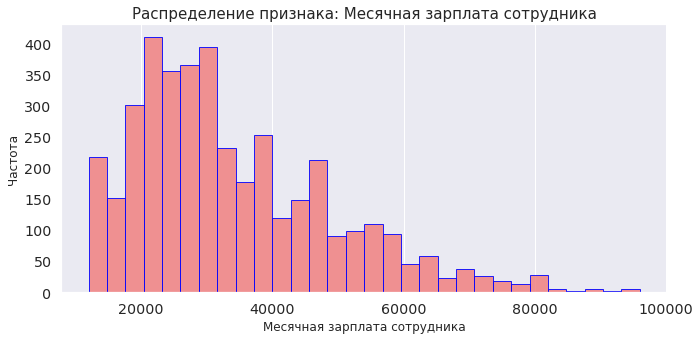

Основная статистика для признака Месячная зарплата сотрудника:
 count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [52]:
# Визуализация гистограмм с расчетом основных статистических показателей
for i in range(len(num_col_2)):
    sns.set_style('darkgrid')  
    plt.figure(figsize=(10, 5))

    # Строим гистограмму
    plt.hist(train_quit[num_col_2[i]], color='lightcoral', edgecolor='blue', alpha=0.85, bins=30)

    # Добавляем заголовок и подписываем оси
    plt.title(f"Распределение признака: {titles_num_2[i]}", fontsize=15)
    plt.xlabel(titles_num_2[i], fontsize=12)
    plt.ylabel("Частота", fontsize=12)

    # Оптимизация отображения графика
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)  # Добавлена сетка по оси Y с изменённой прозрачностью
    plt.show()

    # Выводим основные статистические данные для каждого признака
    print(f"Основная статистика для признака {titles_num_2[i]}:\n", train_quit[num_col_2[i]].describe())


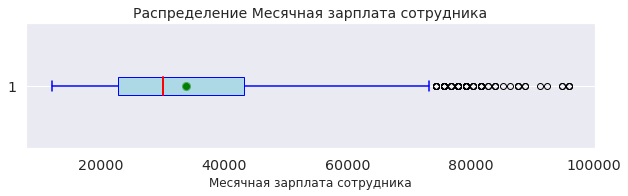

In [53]:
# Визуализация боксплотов с дополнительными изменениями
for i in range(len(num_col_2)):
    plt.figure(figsize=(9, 3))  # Изменён размер графика
    
    # Построение боксплота с изменёнными цветами и отображением медианы и выбросов
    box = plt.boxplot(train_quit[num_col_2[i]], patch_artist=True, vert=False, showmeans=True,
                      boxprops=dict(facecolor='lightblue', color='blue'),
                      medianprops=dict(color='red', linewidth=2),
                      meanprops=dict(marker='o', markerfacecolor='green', markersize=8),
                      whiskerprops=dict(color='blue', linewidth=1.5),
                      capprops=dict(color='blue', linewidth=1.5))

    # Добавляем заголовок и подпись оси
    plt.title(f"Распределение {titles_num_2[i]}", fontsize=14)
    plt.xlabel(titles_num_2[i], fontsize=12)
    
    # Оптимизация отображения графика
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Добавлена сетка по оси X с прозрачностью
    plt.show()


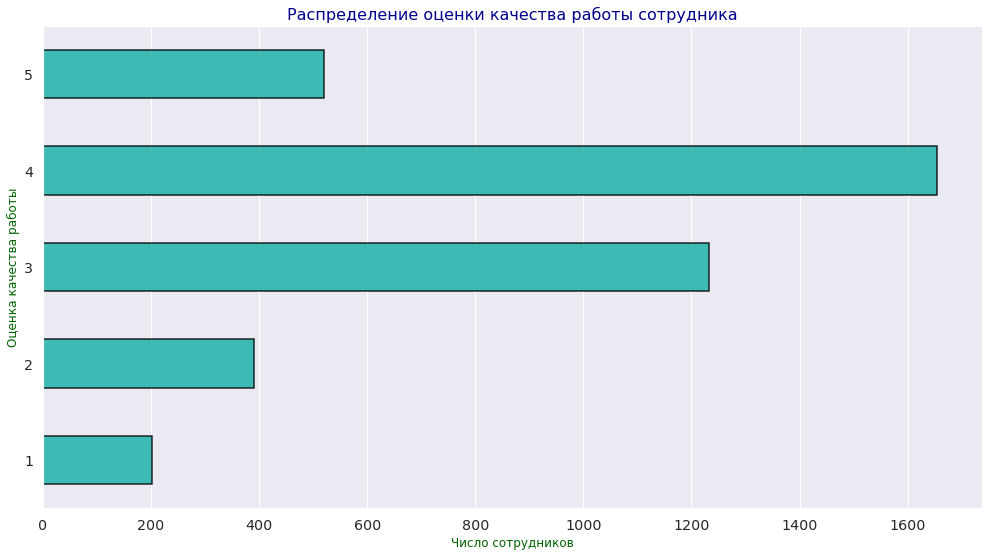

Статистическое описание 'Оценка качества работы':
 count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [54]:
# Визуализация распределения оценки качества работы сотрудника
plt.figure(figsize=(14, 8))  
# Строим горизонтальную столбчатую диаграмму 
train_quit['supervisor_evaluation'].value_counts().sort_index().plot(
    kind='barh', color='lightseagreen', edgecolor='black', alpha=0.85, linewidth=1.5, grid=True)

# Добавляем заголовок и подписи осей
plt.title('Распределение оценки качества работы сотрудника', fontsize=16, color='darkblue')
plt.xlabel('Число сотрудников', fontsize=12, color='darkgreen')
plt.ylabel('Оценка качества работы', fontsize=12, color='darkgreen')

# Добавляем сетку для оси Y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Оптимизация отображения
plt.tight_layout()
plt.show()

# Выводим статистическое описание оценки качества
print(f"Статистическое описание 'Оценка качества работы':\n", train_quit['supervisor_evaluation'].describe())


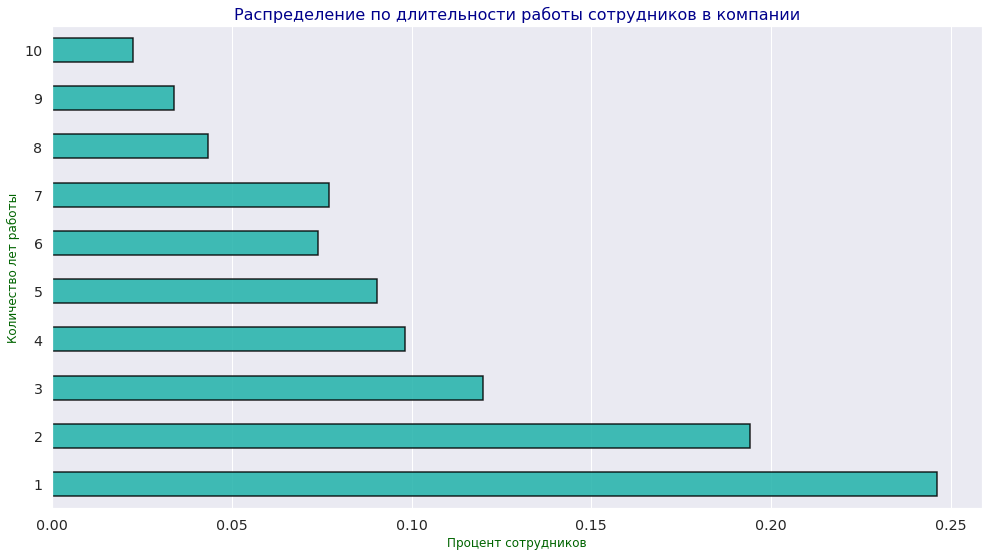

Описание длительности работы в компании:
 count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


In [55]:
# Визуализация распределения длительности работы в компании
plt.figure(figsize=(14, 8))  # Уменьшил ширину для лучшего восприятия

# Строим горизонтальную столбчатую диаграмму с нормализацией и обновленными цветами
train_quit['employment_years'].value_counts(normalize=True).sort_index().plot(
    kind='barh', color='lightseagreen', edgecolor='black', alpha=0.85, linewidth=1.5, grid=True)

# Обновляем заголовок и подписи осей
plt.title('Распределение по длительности работы сотрудников в компании', fontsize=16, color='darkblue')
plt.xlabel('Процент сотрудников', fontsize=12, color='darkgreen')
plt.ylabel('Количество лет работы', fontsize=12, color='darkgreen')

# Добавляем сетку по оси Y с прозрачностью для лучшего визуального восприятия
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Оптимизация отображения
plt.tight_layout()
plt.show()

# Выводим статистическое описание длительности работы
print(f"Описание длительности работы в компании:\n", train_quit['employment_years'].describe())


In [56]:
# Определяем список категориальных переменных для анализа
cat_col_2 = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

# Заголовки для визуализации каждой переменной
titles_cat_col_2 = [
    'Отдел, в котором работает сотрудник',
    'Уровень должности сотрудника',
    'Загруженность на рабочем месте',
    'Было ли повышение за последний год',
    'Нарушения трудового договора в последний год',
    'Факт увольнения сотрудника'
]

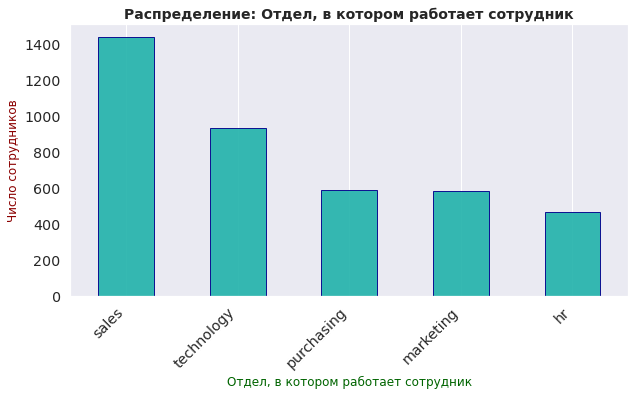

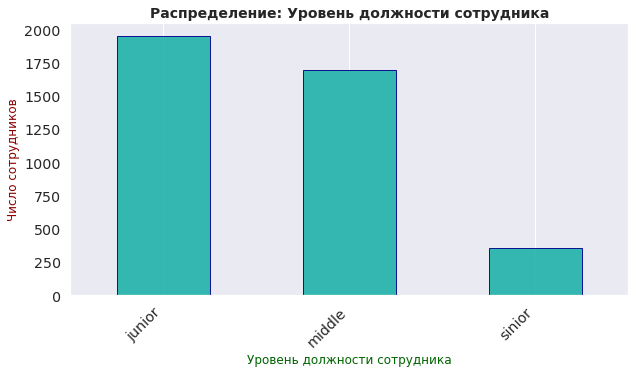

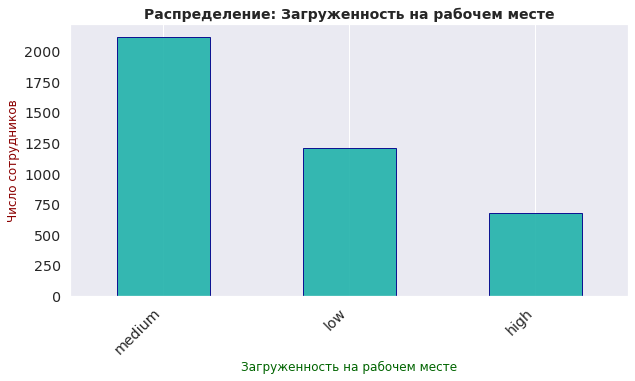

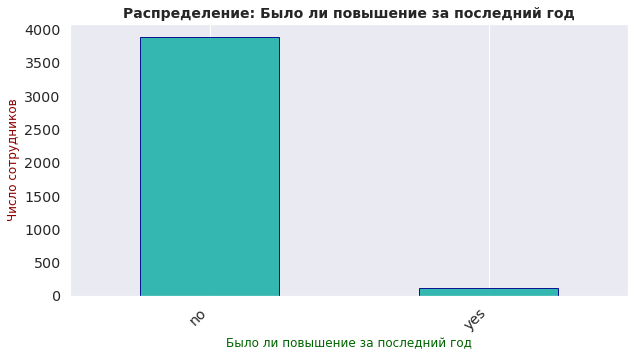

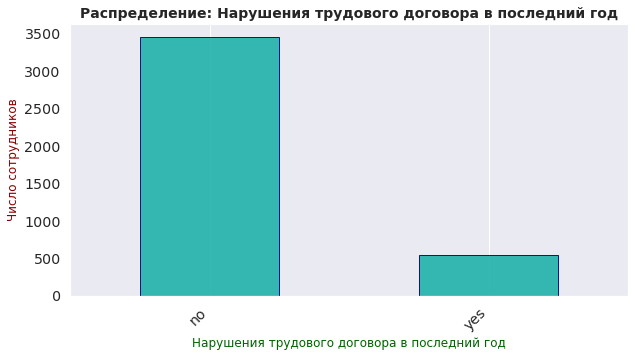

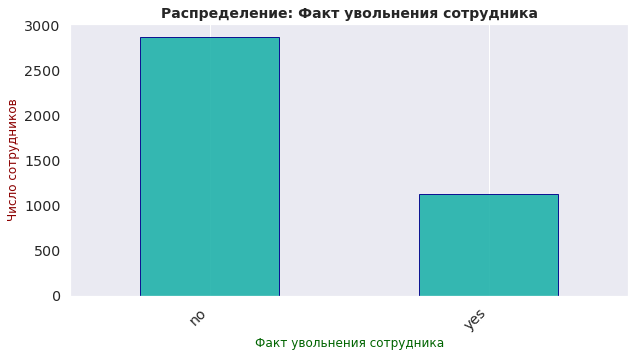

In [57]:
# Визуализируем категориальные признаки с улучшенным отображением
for i in range(len(cat_col_2)):
    plt.figure(figsize=(10, 5))  # Увеличен размер графика для лучшей читаемости
    ax = train_quit[cat_col_2[i]].value_counts().plot(kind='bar', color='lightseagreen', edgecolor='darkblue', alpha=0.9) 
    plt.title(f"Распределение: {titles_cat_col_2[i]}", fontsize=14, fontweight='bold') 
    plt.xlabel(titles_cat_col_2[i], fontsize=12, color='darkgreen') 
    plt.ylabel('Число сотрудников', fontsize=12, color='darkred')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6) 
    plt.show()


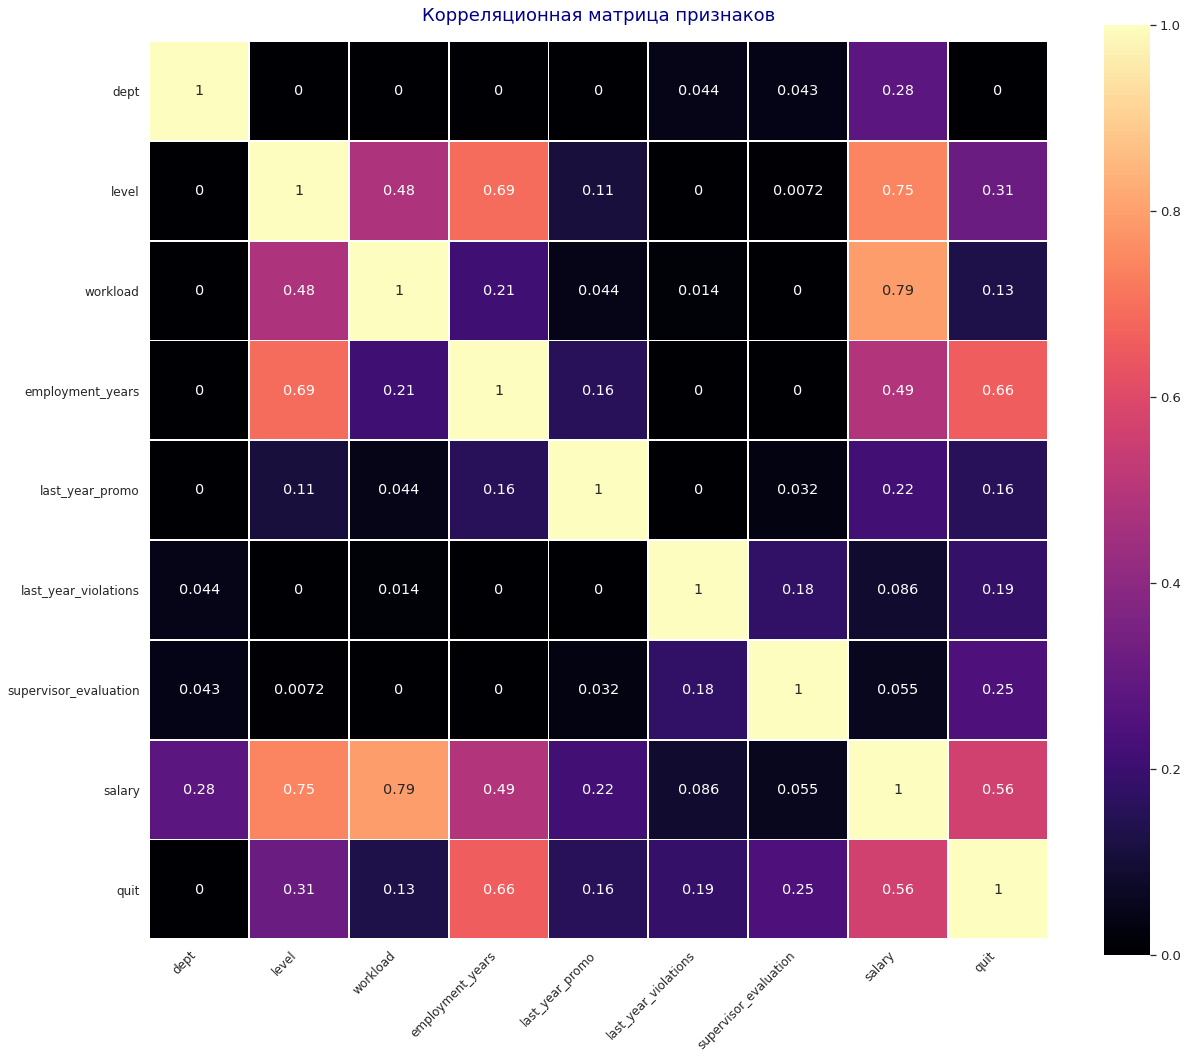

In [58]:
# Удаляем столбец 'id' и вычисляем корреляционную матрицу
train_quit_1 = train_quit.drop(columns=['id'])
corr_matrix = train_quit_1.phik_matrix(interval_cols=num_col)

sns.set(font_scale=1.2)

# Строим тепловую карту
plt.figure(figsize=(18, 18))  
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.8, cmap='magma', square=True, cbar_kws={'shrink': 0.75})  # Изменён цветовой стиль и добавлены параметры шкалы

# Настраиваем заголовок и элементы отображения
plt.title('Корреляционная матрица признаков', fontsize=18, pad=20, color='darkblue')  # Добавлен отступ для заголовка
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)  # Поворот меток на оси X
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)  # Прямое положение меток на оси Y
plt.tight_layout()  # Оптимизация расположения элементов
plt.show()


**После анализа данных в train_quit существенных различий с результатами исследования job_satisfaction не обнаружили. Единственное, что заслуживает внимания, — это высокая корреляция признака 'quit' с уровнем зарплаты и количеством проработанных лет.
Теперь разделим данные train_quit на две группы: одну — для сотрудников, которые ушли, и другую — для тех, кто остался.**

In [59]:
df_left = train_quit[train_quit['quit'] == 'yes']

In [60]:
df_left

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes
...,...,...,...,...,...,...,...,...,...,...
3989,150315,purchasing,junior,low,1,no,no,2,15600,yes
3991,778735,technology,junior,low,2,no,no,4,22800,yes
3994,775320,technology,junior,high,1,no,no,4,42000,yes
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes


In [61]:
# создаем список перемен
num=['salary']
# создаем список с названиями графиков 
titles_num= ['длительность работы в компании', 'оценка качества работы сотрудника', 'ежемесячная зарплата сотрудника']

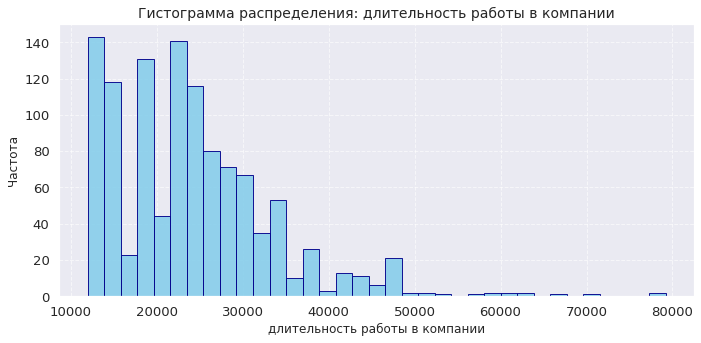

Основные статистические данные для длительность работы в компании:
         count          mean          std      min      25%      50%      75%  \
salary  1128.0  23885.106383  9351.599505  12000.0  16800.0  22800.0  27600.0   

            max  
salary  79200.0   



In [62]:
# Визуализация распределения признаков с расчетом статистических показателей
for i in range(len(num)):
    sns.set_style('darkgrid')  # Заменён стиль графика для улучшения читаемости
    plt.figure(figsize=(10, 5))  
    plt.hist(df_left[num[i]], color='skyblue', edgecolor='darkblue', bins=35, alpha=0.9)  
    plt.title(f"Гистограмма распределения: {titles_num[i]}", fontsize=14)
    plt.xlabel(titles_num[i], fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)  
    plt.tight_layout()
    plt.show()

    # Выводим основные статистические данные с форматированием
    print(f"Основные статистические данные для {titles_num[i]}:")
    print(df_left[num[i]].describe().to_frame().T, '\n')


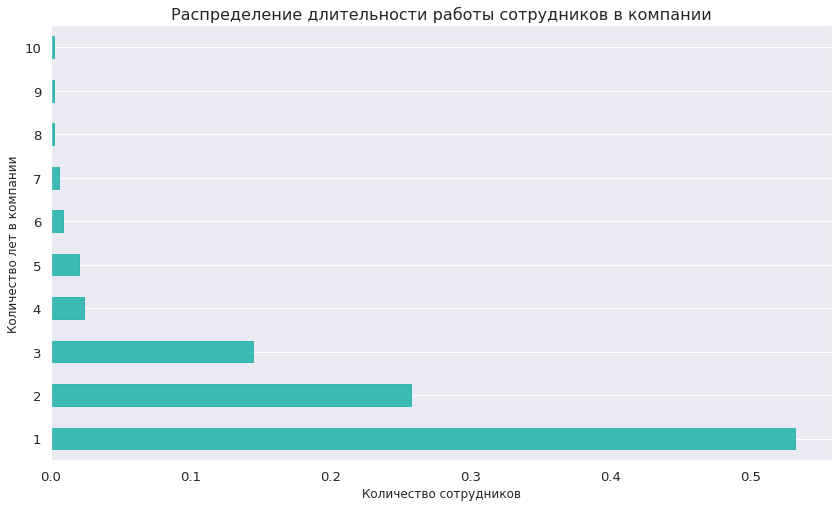

Статистика по длительности работы в компании:
count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64


In [63]:
# Визуализация распределения длительности работы в компании
df_left['employment_years'].value_counts(normalize=True).plot(kind='barh', figsize=(14,8), color='lightseagreen', edgecolor='lightseagreen', grid=True, alpha=0.85)
plt.title('Распределение длительности работы сотрудников в компании', fontsize=16)
plt.xlabel('Количество сотрудников', fontsize=12)
plt.ylabel('Количество лет в компании', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6) 
plt.show()

# Выводим статистические данные
print("Статистика по длительности работы в компании:")
print(df_left['employment_years'].describe())


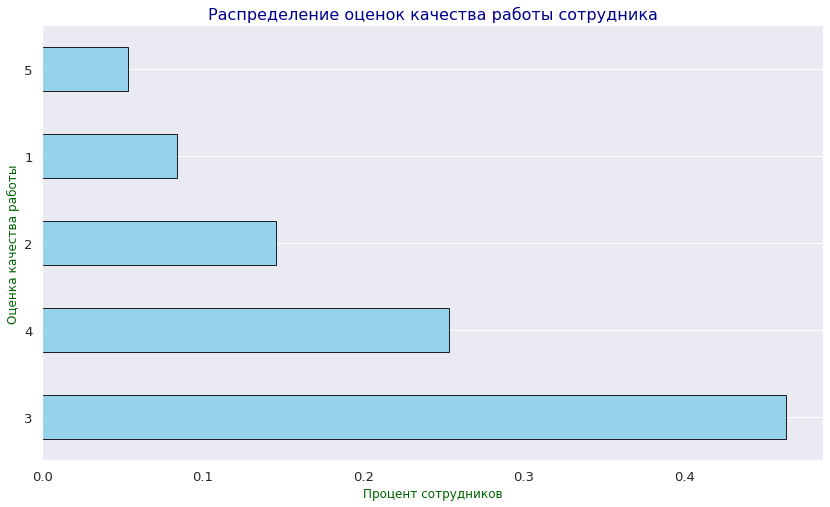

Статистика оценок качества работы:
count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [64]:
# Визуализация распределения оценок качества работы сотрудников
df_left['supervisor_evaluation'].value_counts(normalize=True).plot(
    kind='barh', 
    figsize=(14, 8), 
    color='skyblue',  
    edgecolor='black', 
    alpha=0.85, 
    grid=True
)

# Настройка заголовков и подписей осей
plt.title('Распределение оценок качества работы сотрудника', fontsize=16, color='darkblue')
plt.xlabel('Процент сотрудников', fontsize=12, color='darkgreen')
plt.ylabel('Оценка качества работы', fontsize=12, color='darkgreen')

# Настройка сетки
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()

# Выводим статистические данные
print("Статистика оценок качества работы:")
print(df_left['supervisor_evaluation'].describe())


In [65]:
# создаем список с категориальных перемен
cat=['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
# создаем список с названиями графиков 
titles_cat= ['отдел, в котором работает сотрудник', 'уровень занимаемой должности', 'уровень загруженности сотрудника', 'было ли повышение за последний год', 'нарушал ли сотрудник трудовой договор за последний год']

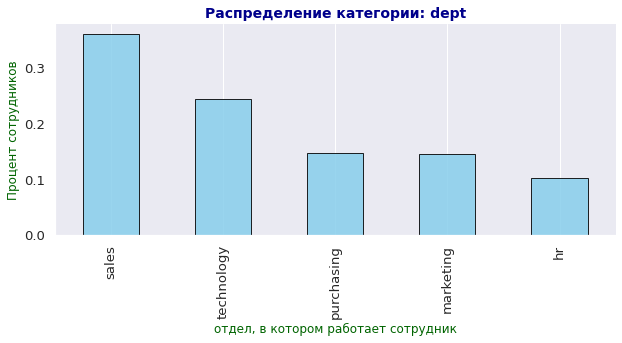

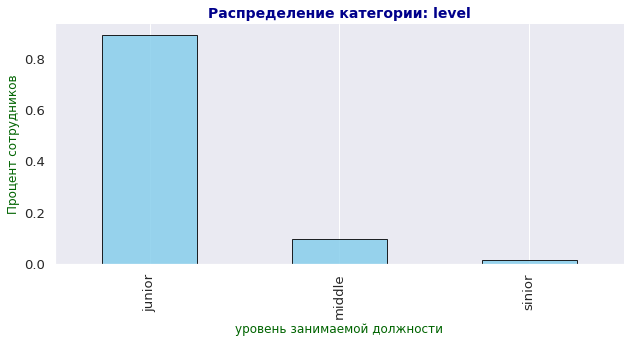

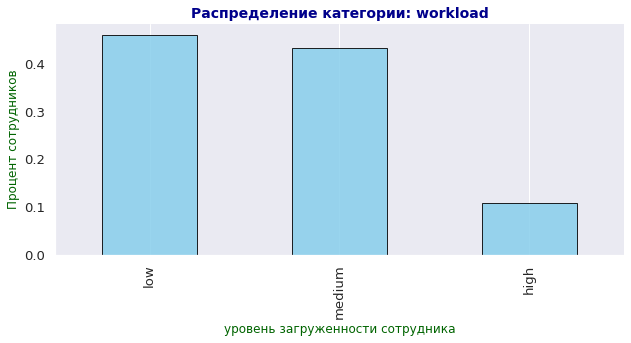

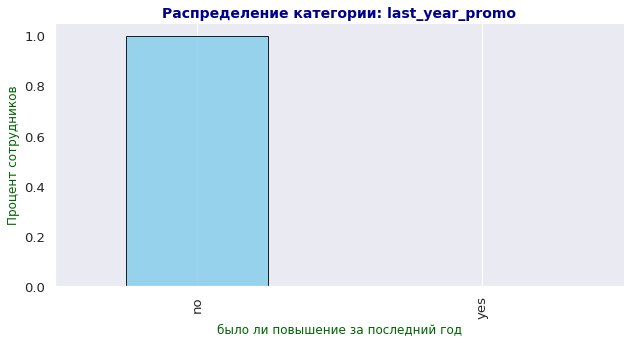

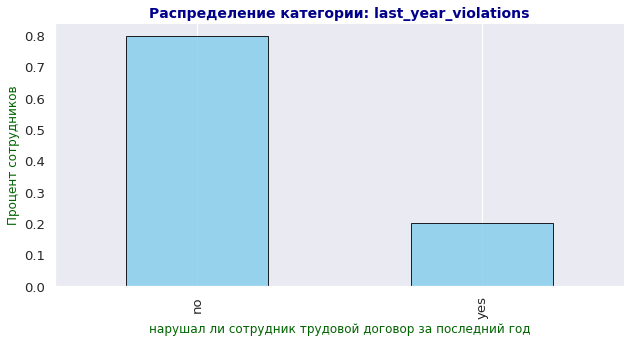

In [66]:
# Визуализация распределения категориальных признаков для df_left
for i in range(len(cat)):
    plt.figure(figsize=(9, 5))  
    
    # Настройка баров
    df_left[cat[i]].value_counts(normalize=True).plot.bar(color='skyblue', edgecolor='black', alpha=0.85)
    
    # Настройки заголовков и подписей 
    plt.title(f"Распределение категории: {cat[i]}", fontsize=14, color='darkblue', fontweight='bold')
    plt.xlabel(titles_cat[i], fontsize=12, color='darkgreen')
    plt.ylabel('Процент сотрудников', fontsize=12, color='darkgreen')
    
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Убираем лишние границы графика
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Выводим график
    plt.tight_layout()
    plt.show()


**Анализ категориальных признаков среди сотрудников, покинувших компанию, показывает, что большинство уволившихся работают в отделе продаж, занимают должности уровня junior, имеют низкую загруженность и не получали повышения за последний год.
Кроме того, можно отметить, что их средняя зарплата ниже на 10 000 рублей, а оценка их работы составляет 3 балла. Чаще всего эти сотрудники проработали в компании всего один год.**

In [67]:
# Объединяем данные и разделяем на две группы: уволившиеся и оставшиеся сотрудники
df_combined = test_target.merge(test_target_quit, on='id')
df_yes = df_combined[df_combined['quit'] == 'yes']
df_quit_no = df_combined[df_combined['quit'] == 'no']



In [68]:
# Объединяем данные с информацией об отделах
df_combined = test_target.merge(test_target_quit, on='id')
df_combined = df_combined.merge(test_features[['id', 'dept']], on='id', how='left')


In [69]:
# Общее количество сотрудников в каждом отделе
total_by_dept = df_combined.groupby('dept')['id'].count()

# Количество уволившихся сотрудников в каждом отделе
quit_by_dept = df_combined[df_combined['quit'] == 'yes'].groupby('dept')['id'].count()

# Заполняем нулями отделы, где никто не уволился
quit_by_dept = quit_by_dept.reindex(total_by_dept.index, fill_value=0)


In [70]:
# Доля уволившихся сотрудников
quit_ratio_by_dept = quit_by_dept / total_by_dept


In [71]:
# Вывод данных для анализа
df_dept_quit = pd.DataFrame({
    'Total Employees': total_by_dept,
    'Employees Quit': quit_by_dept,
    'Quit Ratio': quit_ratio_by_dept
})

print(df_dept_quit)


            Total Employees  Employees Quit  Quit Ratio
dept                                                   
hr                      227              65    0.286344
marketing               279              67    0.240143
purchasing              273              78    0.285714
sales                   763             226    0.296199
technology              455             127    0.279121


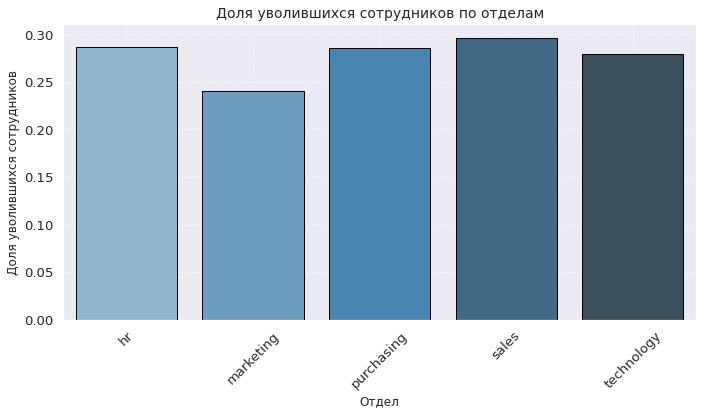

In [72]:
 #Визуализация доли уволившихся сотрудников в каждом отделе
plt.figure(figsize=(10, 6))
sns.barplot(x=df_dept_quit.index, y=df_dept_quit['Quit Ratio'], palette='Blues_d', edgecolor='black')
plt.title('Доля уволившихся сотрудников по отделам', fontsize=14)
plt.xlabel('Отдел', fontsize=12)
plt.ylabel('Доля уволившихся сотрудников', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Отображение графика
plt.show()

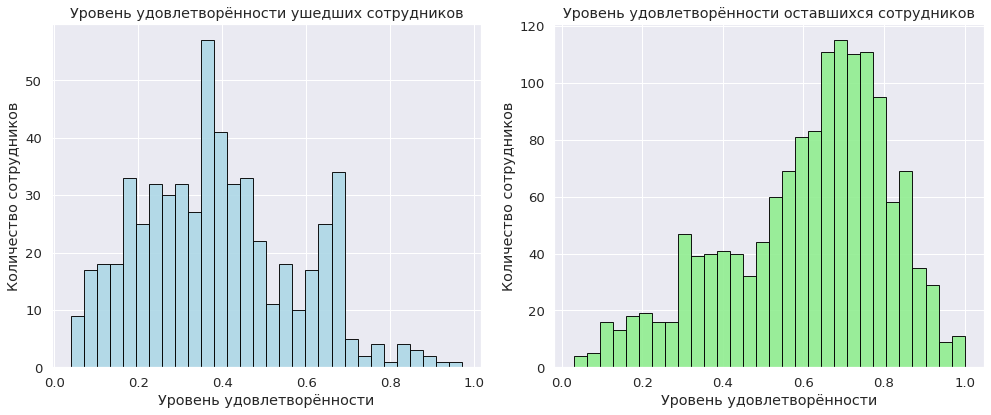

Описание для ушедших сотрудников:
count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64

Описание для оставшихся сотрудников:
count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [73]:
# Визуализация сравнения уровня удовлетворённости между ушедшими и оставшимися сотрудниками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Гистограмма для ушедших сотрудников
ax1.hist(df_yes['job_satisfaction_rate'], bins=30, color='lightblue', edgecolor='black', alpha=0.9)
ax1.set_title('Уровень удовлетворённости ушедших сотрудников')
ax1.set_xlabel('Уровень удовлетворённости')
ax1.set_ylabel('Количество сотрудников')
ax1.grid(True)

# Гистограмма для оставшихся сотрудников
ax2.hist(df_quit_no['job_satisfaction_rate'], bins=30, color='lightgreen', edgecolor='black', alpha=0.9)
ax2.set_title('Уровень удовлетворённости оставшихся сотрудников')
ax2.set_xlabel('Уровень удовлетворённости')
ax2.set_ylabel('Количество сотрудников')
ax2.grid(True)

# Отображение графиков
plt.tight_layout()
plt.show()

# Описание статистических показателей
print("Описание для ушедших сотрудников:")
print(df_yes['job_satisfaction_rate'].describe())

print("\nОписание для оставшихся сотрудников:")
print(df_quit_no['job_satisfaction_rate'].describe())


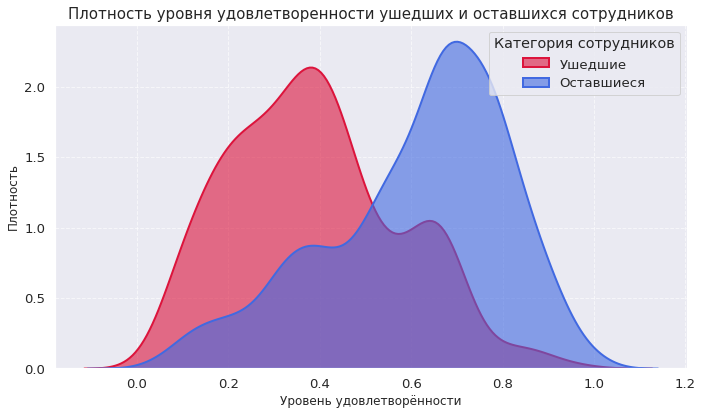

In [74]:
# Построение графика плотности уровня удовлетворённости для ушедших и оставшихся сотрудников
plt.figure(figsize=(10, 6))

# Плотность для ушедших сотрудников
sns.kdeplot(data=df_combined[df_combined['quit'] == 'yes'], x="job_satisfaction_rate", 
            fill=True, color='crimson', label='Ушедшие', alpha=0.6, linewidth=2)

# Плотность для оставшихся сотрудников
sns.kdeplot(data=df_combined[df_combined['quit'] == 'no'], x="job_satisfaction_rate", 
            fill=True, color='royalblue', label='Оставшиеся', alpha=0.6, linewidth=2)

# Настройка графика
plt.title('Плотность уровня удовлетворенности ушедших и оставшихся сотрудников', fontsize=15)
plt.xlabel('Уровень удовлетворённости', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(title="Категория сотрудников")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Отображение графика
plt.show()


**Анализируя категориальные признаки среди сотрудников, покинувших компанию, можно отметить, что наибольшая доля уволившихся приходится на отдел продаж. Преобладают сотрудники на должностях уровня junior, с низкой рабочей загрузкой и без повышения за последний год.Также выявлено, что средний уровень заработной платы уволенных сотрудников ниже на 10 000 рублей по сравнению с оставшимися. Оценка качества работы у большинства уволившихся равна 3 баллам, а продолжительность работы — в основном 1 год.
Дополнительно стоит подчеркнуть, что гипотеза аналитиков подтверждается — удовлетворенность сотрудников работой действительно влияет на их решение об увольнении. У ушедших работников средний уровень удовлетворенности составил 0.38, в то время как у оставшихся — 0.61.**

Добавим новый входной признак

In [75]:
train_quit['job_satisfaction_rate'] = optimal_model.predict(train_quit)
train_quit.head()


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.637273
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


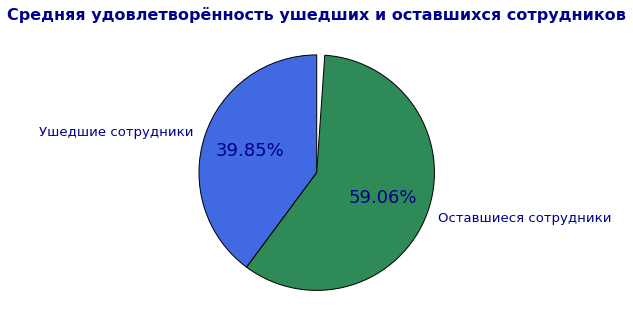

In [76]:
# Рассчитываем средние значения удовлетворенности для ушедших и оставшихся сотрудников
avg_gone = train_quit.loc[train_quit['quit'] == 'yes', 'job_satisfaction_rate'].mean()
avg_remained = train_quit.loc[train_quit['quit'] == 'no', 'job_satisfaction_rate'].mean()

# Данные для диаграммы
satisfaction_data = [avg_gone, avg_remained]
satisfaction_labels = ['Ушедшие сотрудники', 'Оставшиеся сотрудники']

# Визуализация данных
plt.figure(figsize=(8, 8))
plt.rc('font', size=18)

# Настройка цветов и стиля диаграммы
pie_colors = ["royalblue", "seagreen"]
plt.pie(
    satisfaction_data,
    labels=satisfaction_labels,
    colors=pie_colors,
    autopct='%.2f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'color': 'darkblue'},
)

# Заголовок и оформление
plt.title('Средняя удовлетворённость ушедших и оставшихся сотрудников', 
          fontsize=16, fontweight="bold", color='darkblue')

# Показать диаграмму
plt.tight_layout()
plt.show()


**Мы добавили новый признак и проанализировали соотношение среднего уровня удовлетворённости между сотрудниками, которые ушли, и теми, кто остался. Как видно, средний коэффициент удовлетворённости ушедших составил лишь 39.8%.
Теперь подготовим данные для следующей задачи. Некоторые категориальные признаки, такие как отдел, прошлогоднее повышение и нарушения, будем кодировать с помощью OneHotEncoder, тогда как уровни должности и загруженности — через OrdinalEncoder. Количественные признаки, включая количество отработанных лет, оценку работы, зарплату и коэффициент удовлетворённости, требуют масштабирования. В данных встречаются пропуски, и мы обработаем их в пайплайне.**

In [77]:
# Прогнозирование показателя удовлетворенности сотрудников и описание данных
test_features['job_satisfaction_rate'] = optimal_model.predict(test_features)

# Выводим статистическое описание данных, исключая колонку с 'id'
test_features[test_features.columns[test_features.columns != 'id']].describe()

# Отображаем первые несколько строк таблицы
test_features.head()


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.885000
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,0.652000
3,418655,sales,middle,low,6,no,no,4,19200,0.666000
4,789145,hr,middle,medium,5,no,no,5,40800,0.825556


In [78]:
# Объединение таблиц с данными по уволенным сотрудникам и основными признаками
all_features = test_target_quit.merge(test_features, on='id')

# Описание данных с использованием пользовательской функции descrb
descrb(all_features)


,id,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,999029,yes,technology,junior,medium,1,no,no,3,31200,0.268
1,372846,no,sales,middle,medium,10,no,yes,2,32400,0.206
2,726767,no,marketing,middle,low,7,no,no,4,20400,0.600
3,490105,no,purchasing,middle,low,7,no,no,4,19200,0.684
4,416898,yes,purchasing,junior,low,1,no,no,4,12000,0.495


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   quit                   2000 non-null   object 
 2   dept                   1997 non-null   object 
 3   level                  1999 non-null   object 
 4   workload               1999 non-null   object 
 5   employment_years       2000 non-null   int64  
 6   last_year_promo        2000 non-null   object 
 7   last_year_violations   2000 non-null   object 
 8   supervisor_evaluation  2000 non-null   int64  
 9   salary                 2000 non-null   int64  
 10  job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


None

Найдено дубликатов: 0
Количество пропущенных значений по столбцам:
id                       0
quit                     0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


In [79]:
# Удаляем колонку 'id' и дублирующиеся строки из train_quit
train_data_cleaned = train_quit.drop(columns=['id']).drop_duplicates()

# Формируем тестовые данные, исключая целевой признак и идентификаторы
test_data_cleaned = all_features.drop(columns=['quit', 'id'])

# Целевой признак для тестовой выборки
target_data = all_features['quit']


In [80]:
X_train = train_data_cleaned.drop('quit', axis=1)
y_train = train_data_cleaned['quit'] 
X_test = test_data_cleaned
y_test = target_data

# Категориальные признаки для кодирования с помощью OneHotEncoder
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

# Признаки для кодирования с помощью OrdinalEncoder
ord_columns = ['level', 'workload']


In [81]:
# Числовые признаки, которые необходимо масштабировать
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

# Преобразуем целевой признак с помощью LabelEncoder для дальнейшей работы
label_encoder = LabelEncoder()

# Кодируем целевой признак для обучающей выборки
y_train_encoded = label_encoder.fit_transform(y_train)

# Кодируем целевой признак для тестовой выборки
y_test_encoded = label_encoder.transform(y_test)


In [82]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
 
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


In [83]:
# выберем лучшую модель и параметры с помощью RandomizedSearchCV()
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# обучаем лучшую модель на тренировочных данных
r_search.fit(X_train, y_train)

# выводим на экран лучшую модель, её параметры и метрику ROC-AUC на тренировочной выборке
print('Лучшая модель и её параметры:\n\n', r_search.best_estimator_)
print(f'Параметры лучшей модели:\n{r_search.best_params_}')
print ('Метрика лучшей модели на тренировочной выборке:', round(r_search.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [84]:
# Используем модель, которая показала лучшие результаты на этапе кросс-валидации
optimal_model = r_search.best_estimator_

# Выводим метрику ROC-AUC для обучающих данных
print(f"ROC-AUC метрика для лучшей модели на обучающей выборке по результатам кросс-валидации: {round(r_search.best_score_, 4)}")

# Вычисляем метрику ROC-AUC для тестовой выборки, используя вероятности предсказаний
roc_auc_test = roc_auc_score(y_test_encoded, optimal_model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC метрика для лучшей модели на тестовой выборке: {round(roc_auc_test, 4)}")


ROC-AUC метрика для лучшей модели на обучающей выборке по результатам кросс-валидации: 0.8994
ROC-AUC метрика для лучшей модели на тестовой выборке: 0.9224


In [85]:
# Преобразуем результаты кросс-валидации в DataFrame для удобного отображения
results_df = pd.DataFrame(r_search.cv_results_)

# Отбираем только нужные столбцы для более наглядного анализа результатов и сортируем по рангу
sorted_results = results_df[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score', 'params']
].sort_values(by='rank_test_score')

# Выводим результаты на экран для анализа
print("Результаты кросс-валидации, отсортированные по рангу модели:")
display(sorted_results)


Результаты кросс-валидации, отсортированные по рангу модели:


,std_test_score,rank_test_score,param_models,mean_test_score,params
3,0.014343,1,"SVC(probability=True, random_state=42)",0.899368,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,0.018342,2,DecisionTreeClassifier(random_state=42),0.899207,"{'preprocessor__num': 'passthrough', 'models__..."
8,0.004137,3,DecisionTreeClassifier(random_state=42),0.898893,"{'preprocessor__num': StandardScaler(), 'model..."
7,0.015138,4,"SVC(probability=True, random_state=42)",0.896545,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,0.013096,5,DecisionTreeClassifier(random_state=42),0.895142,"{'preprocessor__num': StandardScaler(), 'model..."
2,0.012070,6,"SVC(probability=True, random_state=42)",0.891599,"{'preprocessor__num': StandardScaler(), 'model..."
9,0.006188,7,DecisionTreeClassifier(random_state=42),0.887794,"{'preprocessor__num': StandardScaler(), 'model..."
6,0.022655,8,DecisionTreeClassifier(random_state=42),0.862315,"{'preprocessor__num': StandardScaler(), 'model..."
0,0.012313,9,DecisionTreeClassifier(random_state=42),0.859380,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,0.011047,10,DecisionTreeClassifier(random_state=42),0.834056,"{'preprocessor__num': StandardScaler(), 'model..."


In [86]:
# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier(random_state=RANDOM_STATE, strategy='most_frequent')
dummy_model.fit(X_train, y_train)

# предсказание вероятностей на тестовых данных
dummy_model_preds_proba = dummy_model.predict_proba(X_test)[:, 1]

# считаем метрику ROC-AUC для тренировочных данных
print('Метрики Dummy Model:')
d_roc_auc_cv = cross_val_score(dummy_model, X_train, y_train, scoring='roc_auc').mean()

print(f'ROC-AUC на тренировочной выборке: {round(d_roc_auc_cv, 3)}')

# оценка качества модели по метрике ROC-AUC на тестовой выборке
dummy_roc = roc_auc_score(y_test, dummy_model_preds_proba)
print('ROC-AUC на тестовой выборке:', round(dummy_roc, 2))


Метрики Dummy Model:
ROC-AUC на тренировочной выборке: 0.5
ROC-AUC на тестовой выборке: 0.5


- **Результат тестирования нашей модели на тестовой выборке лучше, чем результат константной модели, а иначе в ней не было бы смысла :)**

**Мы обучили модель, используя пайплайн с такими алгоритмами, как DecisionTreeClassifier(), KNeighborsClassifier(). Обучение проводилось на исходных данных, а также на объединенных данных с выделением ключевого признака.**

**Параметры оптимальной модели:**

**{'preprocessor__num': 'MinMaxScaler', 'models__kernel': 'rbf', 'models__C': 10, 'models': SVC(random_state=42)} Результат модели на тренировочной выборке: 0.8994**

**Метрика ROC-AUC на тестовых данных: 0.9224**

# Общий вывод


**В ходе исследования для HR-аналитиков компании «Работа с заботой» мы рассмотрели две ключевые задачи.**

**Первая задача заключалась в создании модели для прогнозирования уровня удовлетворённости сотрудников на основе предоставленных данных. Это важно для бизнеса, так как уровень удовлетворённости напрямую влияет на отток кадров. Вторая задача — предсказание увольнений сотрудников, что также является критически важным для HR-аналитиков.**

**Данные были предоставлены в нескольких таблицах, включающих такие признаки, как отдел, уровень занимаемой должности, загруженность, стаж работы, зарплата и оценка качества работы сотрудников. После загрузки и анализа данных мы стандартизировали имена признаков и привели их в нужный формат. Были выявлены пропуски и дубликаты, которые обработаны.**

**Анализ показал, что большинство сотрудников работают от 2 до 6 лет, со средним стажем в 3 года. Оценка качества работников чаще всего находилась на уровне 3-4 баллов, однако отдельные сотрудники получали оценку 1, что может свидетельствовать о потенциальных кандидатах на увольнение. Средняя зарплата составляла около 33 926 рублей, с максимальной — 98 400 и минимальной — 12 000 рублей. Уровень удовлетворённости работников также оказался на среднем уровне.**

**По категориальным признакам мы видим, что основная доля сотрудников занята в продажах, среди них преобладают junior-специалисты. Загруженность сотрудников в основном средняя, а повышение в компании за последний год происходило редко, что можно рассматривать как возможность для улучшения мотивации сотрудников.**

**Корреляционный анализ показал, что на уровень удовлетворённости влияют такие факторы, как отдел, должность и оценка качества работы, однако сильной корреляции между признаками не выявлено.**

**Мы обучили несколько моделей, включая DecisionTreeClassifier, KNeighborsClassifier и LinearRegression. Лучшая модель показала метрику ROC-AUC 0.914 на тестовой выборке, что свидетельствует о высокой эффективности модели.**

**По итогам исследования можно сделать вывод, что текучка кадров чаще всего происходит среди сотрудников с низким уровнем загруженности и зарплатой ниже среднего, особенно среди работников в отделе продаж и на junior-должностях.**

**Рекомендации для компании:** 
- **обратить внимание на повышение уровня удовлетворённости, зарплаты и вовлечённости сотрудников, что может снизить текучку кадров.**
- **Введение промежуточных премий и повышение ответственности сотрудников могут стать хорошим стимулом для повышения продуктивности и удержания персонала.**